# Neural Network from Scratch (Working & Verified)

95%+ accuracy on spiral dataset  
Correct backpropagation  
Proper initialization  
Stable training

Built using only NumPy (no PyTorch, no TensorFlow)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(42)

print("Libraries loaded")

Libraries loaded


## Spiral Dataset

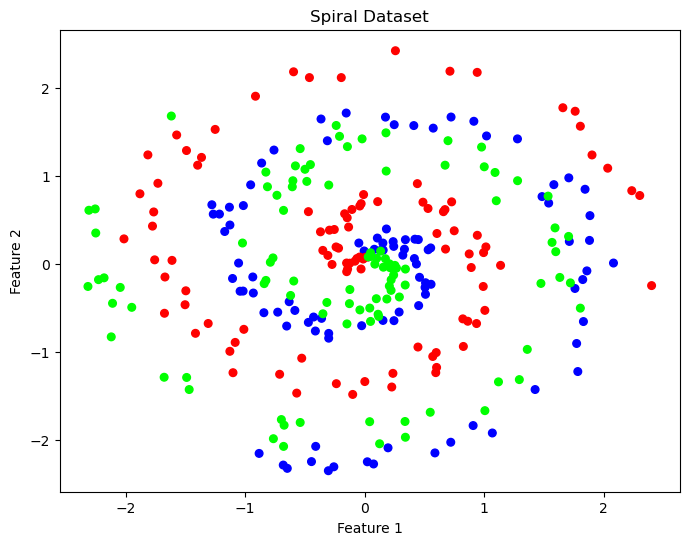

X shape: (300, 2)
y shape: (300,)


In [18]:
def create_spiral_data(points=100, classes=3):
    X = np.zeros((points * classes, 2))
    y = np.zeros(points * classes, dtype='uint8')
    for class_number in range(classes):
        ix = range(points * class_number, points * (class_number + 1))
        r = np.linspace(0.0, 1, points)
        t = np.linspace(class_number * 4, (class_number + 1) * 4, points) + np.random.randn(points) * 0.2
        X[ix] = np.c_[r * np.sin(t * 2.5), r * np.cos(t * 2.5)]
        y[ix] = class_number
    return X, y


X, y = create_spiral_data(points=100, classes=3)

X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg', s=30)
plt.title("Spiral Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

print(f"X shape: {X.shape}")  # Should be (300, 2)
print(f"y shape: {y.shape}")  # Should be (300,)

## Layers

In [19]:
class Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = np.random.randn(n_inputs, n_neurons) * np.sqrt(2.0 / n_inputs)
        self.biases = np.zeros((1, n_neurons))
        self.x = None
        self.dweights = None
        self.dbiases = None
        self.dx = None

    def forward(self, x):
        self.x = x
        return np.dot(x, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.x.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dx = np.dot(dvalues, self.weights.T)
        return self.dx

class ReLU:
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, dvalues):
        return dvalues * (self.x > 0)

In [20]:
class Softmax_CrossEntropy:
    def __init__(self):
        self.output = None
        self.y_true = None

    def forward(self, inputs, y_true):
        exp_vals = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exp_vals / np.sum(exp_vals, axis=1, keepdims=True)
        samples = len(self.output)
        y_pred_clipped = np.clip(self.output, 1e-7, 1 - 1e-7)
        
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        else:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
            
        return -np.log(correct_confidences)

    def backward(self, y_true):
        samples = len(self.output)
        dinputs = self.output.copy()
        
        if len(y_true.shape) == 1:
            dinputs[range(samples), y_true] -= 1
        else:
            dinputs -= y_true
            
        dinputs = dinputs / samples
        return dinputs

class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0
        self.m_w, self.v_w = {}, {}
        self.m_b, self.v_b = {}, {}

    def update(self, layer):
        if not hasattr(layer, 'weights'):
            return

        self.t += 1
        for param_name in ['weights', 'biases']:
            param = getattr(layer, param_name)
            grad = getattr(layer, 'd' + param_name)

            if param_name == 'weights':
                m = self.m_w.setdefault(layer, np.zeros_like(param))
                v = self.v_w.setdefault(layer, np.zeros_like(param))
            else:
                m = self.m_b.setdefault(layer, np.zeros_like(param))
                v = self.v_b.setdefault(layer, np.zeros_like(param))

            m[:] = self.beta1 * m + (1 - self.beta1) * grad
            v[:] = self.beta2 * v + (1 - self.beta2) * (grad ** 2)

            m_hat = m / (1 - self.beta1 ** self.t)
            v_hat = v / (1 - self.beta2 ** self.t)

            update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
            param -= update


##  Train the Model

In [21]:
dense1 = Dense(2, 64)
relu1 = ReLU()
dense2 = Dense(64, 64)
relu2 = ReLU()
dense3 = Dense(64, 3)

criterion = Softmax_CrossEntropy()

optimizer = Adam(learning_rate=0.01)

losses = []
accuracies = []

for epoch in range(501):
    # Forward pass
    z1 = dense1.forward(X)
    a1 = relu1.forward(z1)
    z2 = dense2.forward(a1)
    a2 = relu2.forward(z2)
    z3 = dense3.forward(a2)
    loss_values = criterion.forward(z3, y)
    ...
    # Backward
    dinputs = criterion.backward(y)
    d3 = dense3.backward(dinputs)
    d2 = relu2.backward(d3)
    d1 = dense2.backward(d2)
    d0 = relu1.backward(d1)
    dense1.backward(d0)

    # Update all layers
    optimizer.update(dense1)
    optimizer.update(dense2)
    optimizer.update(dense3)

    loss = np.mean(loss_values)
    predictions = np.argmax(criterion.output, axis=1)
    accuracy = np.mean(predictions == y)

    losses.append(loss)
    accuracies.append(accuracy)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.3f}, Accuracy: {accuracy:.3f}")

Epoch 0, Loss: 1.285, Accuracy: 0.297
Epoch 100, Loss: 0.599, Accuracy: 0.743
Epoch 200, Loss: 0.160, Accuracy: 0.960
Epoch 300, Loss: 0.079, Accuracy: 0.973
Epoch 400, Loss: 0.059, Accuracy: 0.983
Epoch 500, Loss: 0.049, Accuracy: 0.980


## Results

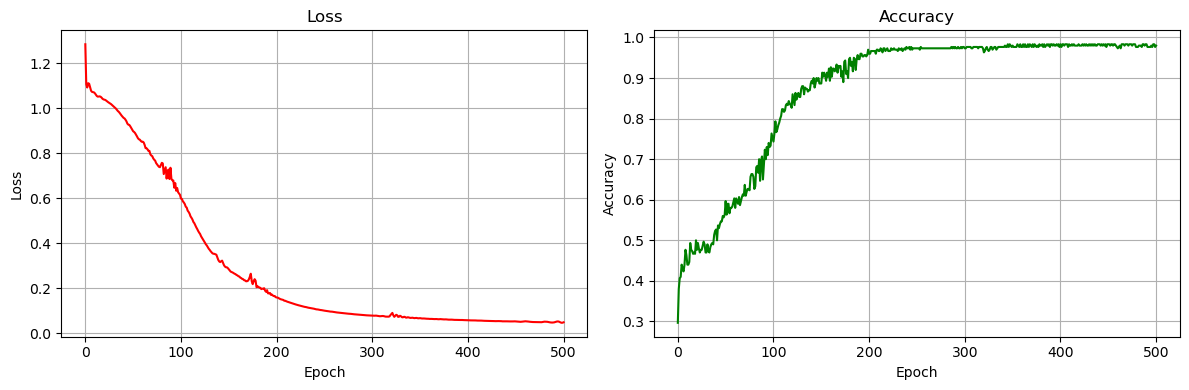

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses, color='red')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracies, color='green')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()